# Replication of the I&F Model
**Group Members:**  Aariz Jivani, Arden Scourtis, Kyra Miller, Martin Gerstle, Monish Jampala, Vishaal Jamched, Zoe Humphrey


An **Integrate & Fire model (IF)** is the <ins>simplest fundamental electrical model</ins> of a neuron. It includes: 
* Input (*current (i)*)
* Integrator (Σ)
* Spike Generator (f)
* Output (*voltage (v)*)

This model is a representation of how neurons respond to a stimulus. In this model, membrane potential increases in a linear fashion from _i → Σ → f → v_ and does not decay over time.

The IF model sacrifices some fidelity to achieve its simplicity, as it fails to incorporate leaky ion channels as well as voltage-gated ion channels. When plotting membrane voltage (V$_{m}$), the IF model shows an immediate, binary activation under stimulation instead of the sloping change experimentally recorded as a result of this simplicity. In addition, immediately after an action potential, current is automatically reset. 

For a more in-depth mathematical breakdown, refer to this [PDF.](https://goldmanlab.faculty.ucdavis.edu/wp-content/uploads/sites/263/2016/07/IntegrateFire.pdf)



**Integrate and Fire Model Code**

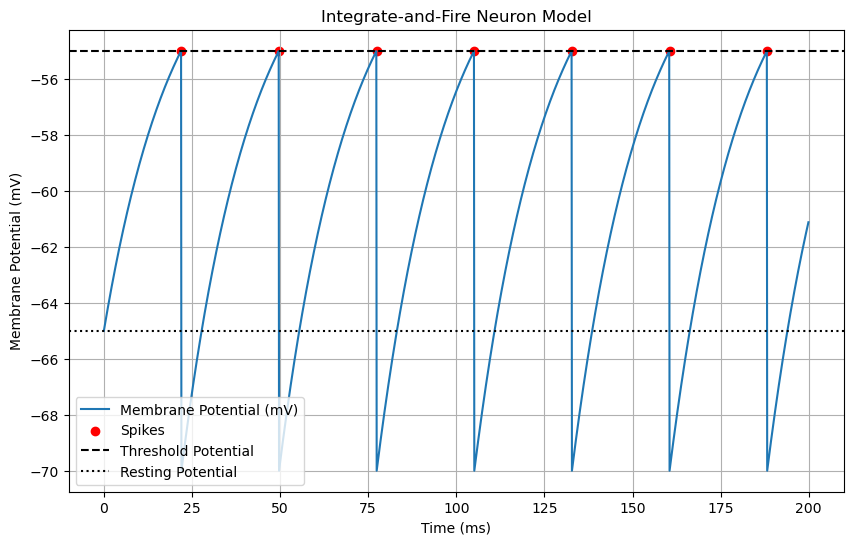

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
resting_potential = -65  # Resting potential in mV
threshold_potential = -55  # Threshold potential in mV
reset_potential = -70  # Reset potential after spike in mV
membrane_time_constant = 20  # Membrane time constant in ms
membrane_resistance = 10  # Membrane resistance in MOhm
input_current = 1.5  # Input current in nA
simulation_time = 200  # Total simulation time in ms
dt = 0.1  # Time step in ms

# Initialize variables
time_steps = np.arange(0, simulation_time, dt)
membrane_potential = np.full_like(time_steps, resting_potential)
spikes = np.zeros_like(time_steps)

# Simulate the neuron
for i in range(1, len(time_steps)):
    # Update membrane potential
    dV = (resting_potential - membrane_potential[i-1] + membrane_resistance * input_current) / membrane_time_constant
    membrane_potential[i] = membrane_potential[i-1] + dV * dt

    # Check for spike
    if membrane_potential[i] >= threshold_potential:
        membrane_potential[i] = reset_potential  # Reset after spike
        spikes[i] = 1  # Record spike

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, membrane_potential, label="Membrane Potential (mV)")
plt.scatter(time_steps[spikes == 1], [threshold_potential] * int(np.sum(spikes)), color="red", label="Spikes")
plt.axhline(threshold_potential, color="k", linestyle="--", label="Threshold Potential")
plt.axhline(resting_potential, color="k", linestyle=":", label="Resting Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Integrate-and-Fire Neuron Model")
plt.legend()
plt.grid()
plt.show()

While the I&F model lacks the complexity of biological neurons, it demonstrates the basic mechanisms of neuronal transmission, such as receiving inputs, integrating them, and generating spikes (action potentials) once the threshold has been met. Despite this, the absence of voltage-gated or leaky ion channels fails to accurately reflect neuronal dynamics. Instead, the I&F model exhibits a membrane potential that rises linearly until the threshold has been met and the generation of sudden spikes followed by an immediate reset (no refractory period). 

The **Leaky Integrate and Fire (LIF)** model extends the I&F model by incorporating ‘leaky’ ion channels, allowing for the more natural decay of the membrane potential overtime (as opposed to the harsh ‘reset’ used in the I&F model). The LIF model accounts for ions freely passing through leaky ion channels in the cell membrane. This makes the LIF model more biologically realistic and a more complex electrical model of the neuron. 

Once current is injected, voltage increases non-linearly (opposed to the IF model), due to current escaping through leaky channels. Once threshold is reached, current leaks out non linearly which allows for the representation of post-spike voltage resets or a delay between spikes.

The **Hodgkin Huxley (HH)** model builds off of the LIF and IF models by incorporating voltage gated channels. Introducing sodium and potassium channels into the mathematical models allows for a more realistic description of neuronal activity.

Once current is injected, voltage increases non linearly (due to current escaping through leaky channels as seen in the LIF model) until threshold is reached. If threshold is reached, voltage gated sodium channels will open to drive the action potential. To mimic membrane potentials and action potentials, conductance changes are utilized in the HH model. Following the action potential, voltage gated potassium channels open to drive repolarization, which then leads into hyperpolarization.

The HH model is one of the most complex mathematical models of a neuron.

**Hodgkin Huxley Model Code**

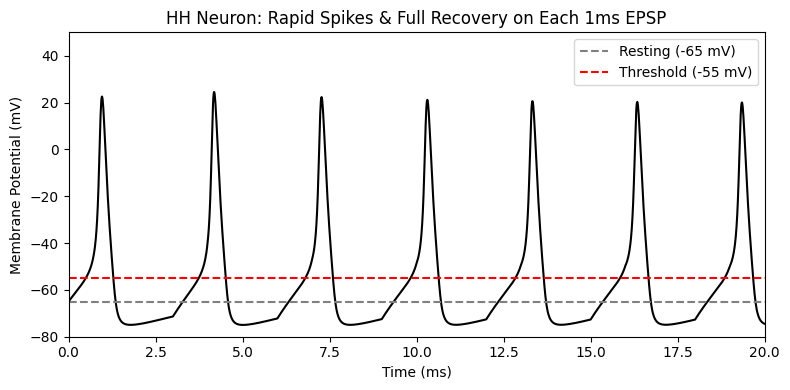

In [5]:
C_m  = 1.0       # membrane capacitance (µF/cm^2)
g_Na = 120.0     # max sodium conductance (mS/cm^2)
g_K  = 36.0      # max potassium conductance (mS/cm^2)
g_L  = 0.3       # leak conductance (mS/cm^2); also changed this value to modify leaky conductance for other visualizations

E_Na = 50.0      # Na+ reversal potential (mV)
E_K  = -77.0     # K+ reversal potential (mV)
E_L  = -54.4     # leak reversal potential (mV)

V_rest = -65.0   # resting potential (mV)
V_th   = -55.0   # threshold potential (mV) for reference lines

# -- Increased gating-speed factor --
# The classic HH model is relatively slow; we speed it up to shorten AP duration.
phi = 6.0     # Changed this value to modify the temperature in the other visualizations

def alpha_m(V):
    return 0.1*(V + 40.0)/(1.0 - np.exp(-(V+40.0)/10.0))

def beta_m(V):
    return 4.0*np.exp(-(V + 65.0)/18.0)

def alpha_h(V):
    return 0.07*np.exp(-(V + 65.0)/20.0)

def beta_h(V):
    return 1.0/(1.0 + np.exp(-(V + 35.0)/10.0))

def alpha_n(V):
    return 0.01*(V + 55.0)/(1.0 - np.exp(-(V+55.0)/10.0))

def beta_n(V):
    return 0.125*np.exp(-(V + 65.0)/80.0)

# ------------------------------------------------------------------------------
# 2. EPSP-like current injection
#    - 1 ms pulses at 0, 3, 6, 9, 12, 15, 18 ms
# ------------------------------------------------------------------------------
def I_inj(t):
    pulse_starts = np.arange(0, 20, 3)  # 0, 3, 6, 9, 12, 15, 18
    I_amp = 20.0  # amplitude in µA/cm^2, ensures each EPSP crosses threshold

    for t_start in pulse_starts:
        if t_start <= t < (t_start + 1.0):  # 1 ms duration
            return I_amp
    return 0.0

# ------------------------------------------------------------------------------
# 3. Simulation parameters
# ------------------------------------------------------------------------------
Tmax = 20.0     # total simulation time (ms)
dt = 0.01       # time step (ms)
num_steps = int(Tmax / dt)
time = np.arange(0, Tmax, dt)

# ------------------------------------------------------------------------------
# 4. Initialize state variables
# ------------------------------------------------------------------------------
V = np.zeros(num_steps)
m = np.zeros(num_steps)
h = np.zeros(num_steps)
n = np.zeros(num_steps)

V[0] = V_rest
m[0] = alpha_m(V_rest)/(alpha_m(V_rest)+beta_m(V_rest))
h[0] = alpha_h(V_rest)/(alpha_h(V_rest)+beta_h(V_rest))
n[0] = alpha_n(V_rest)/(alpha_n(V_rest)+beta_n(V_rest))

# ------------------------------------------------------------------------------
# 5. Integrate the HH equations (Euler method) with speed-up factor phi
# ------------------------------------------------------------------------------
for i in range(num_steps - 1):
    v  = V[i]
    mm = m[i]
    hh = h[i]
    nn = n[i]

    # Ionic currents
    I_Na = g_Na * (mm**3) * hh * (v - E_Na)
    I_K  = g_K  * (nn**4) * (v - E_K)
    I_L  = g_L  * (v - E_L)
    
    # Net membrane current: injection minus ionic
    I_tot = I_inj(time[i]) - (I_Na + I_K + I_L)

    # Derivative of membrane potential
    dV = I_tot / C_m

    # Gating variable derivatives, each multiplied by phi for faster dynamics
    dm = phi * ( alpha_m(v)*(1.0 - mm) - beta_m(v)*mm )
    dh = phi * ( alpha_h(v)*(1.0 - hh) - beta_h(v)*hh )
    dn = phi * ( alpha_n(v)*(1.0 - nn) - beta_n(v)*nn )

    # Euler update
    V[i+1] = v  + dV*dt
    m[i+1] = mm + dm*dt
    h[i+1] = hh + dh*dt
    n[i+1] = nn + dn*dt

# ------------------------------------------------------------------------------
# 6. Plot results
# ------------------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(time, V, 'k')

plt.xlim([0, 20])
plt.ylim([-80, 50])  # Enough range to see full AP
plt.axhline(V_rest, color='gray', linestyle='--', label='Resting (-65 mV)')
plt.axhline(V_th,   color='red',  linestyle='--', label='Threshold (-55 mV)')

plt.title('HH Neuron: Rapid Spikes & Full Recovery on Each 1ms EPSP')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Modified Temperature (Phi)**

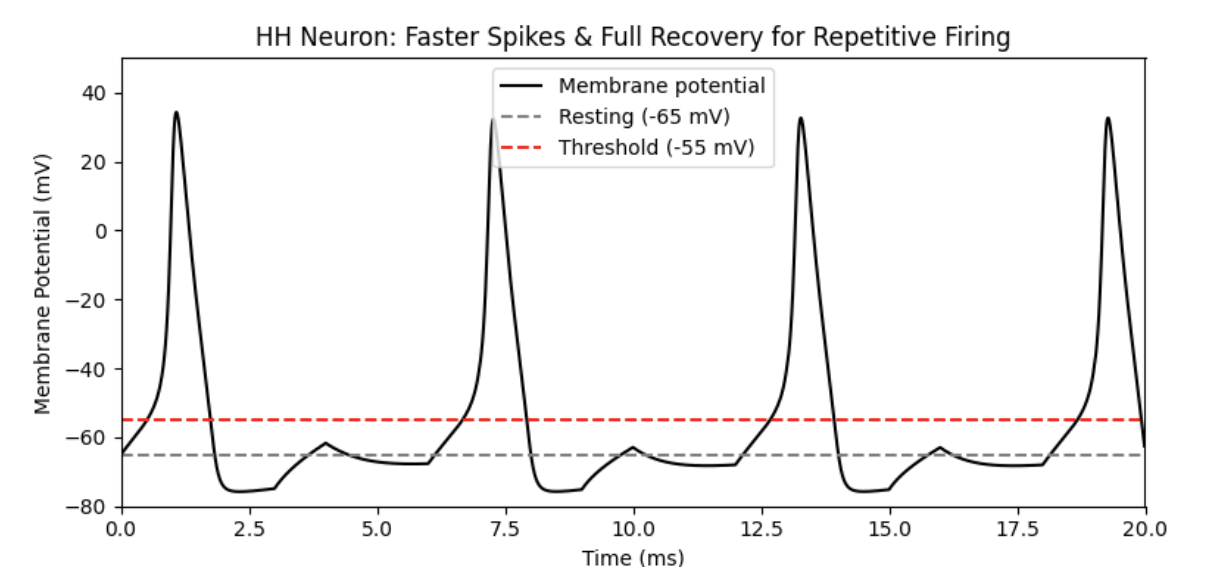

Changed the phi (gating rate / temperature factor) from "phi = 6.0" to 3.0 (line 197). This slowed the rate at which the neuron leaves its refractory period, meaning a current of 20 amps will not fully change the membrane potential by 20mv. In simple, we decreased how fast the neuron would be able to fire again.

**Modified Leaky Conductance**

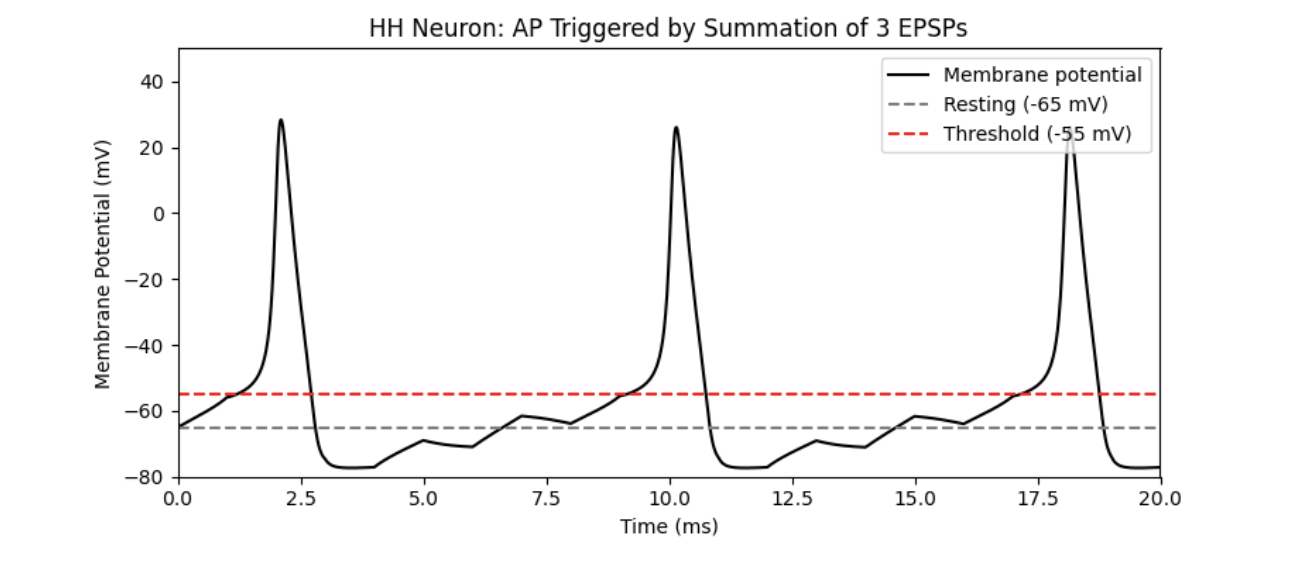

Leak conductance was changed from "g_L = 0.3" to 0.1 (line 186) so that less current could leak out of the system. Current amplitude was changed from "I_amp = 20.0" to 11.0 (line 223), and the rate of pulses was changed from every 3ms to every 2ms. This was reflected in the code as "pulse_starts = np.arange(0,20,2)" (line 222). These changes allowed more potential to be maintained in the system, and allowed for more pulses to be sent within the same amount of time, allowing for temporal summation to be visualized. (These edits were made from the above graph, not the original. This means that the temperature factor was also 3 for this visualization, rather than 6.)

**Hodgkin Huxley Model Modified with Inhibitory Inputs**

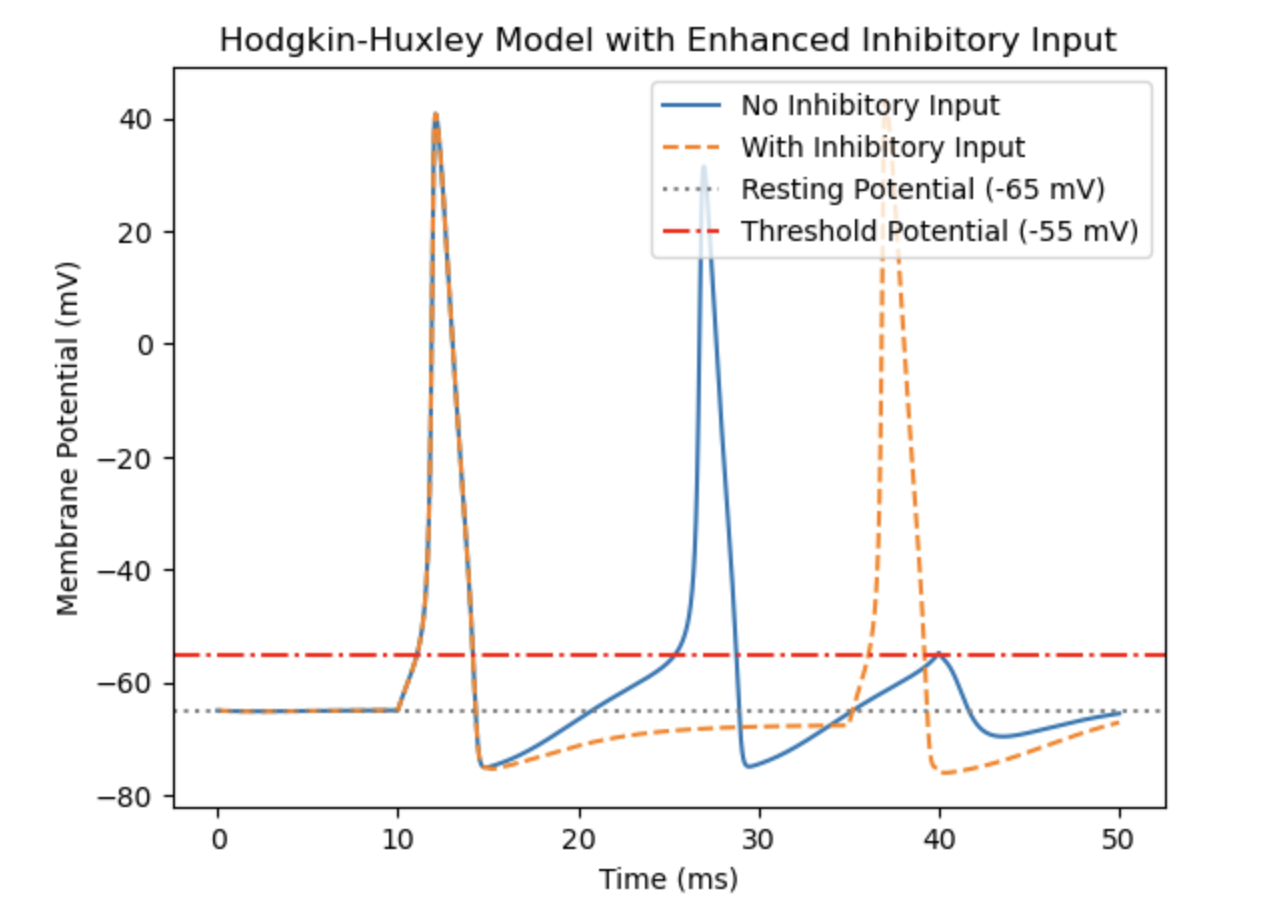

Adding inhibitory inputs required the addition of an inhibitory synaptic current,

*I_syn = g_syn $\cdot$ s $ \cdot$ (V_inhib-E_syn)* 

where g$_{syn}$ = 1.0 is the synaptic conductance, E$_{syn}$ = -80.0 is the inhibitory reversal potential, and *s* is the binary synaptic gating variable, signaling the activation of inhibitory input. When the inhibitory input is activated at (15 ms), it counteracts the total membrane current and causes the membrane potential to become hyperpolarized. This makes it more difficult to reach the threshold and fire an action potential. 

**Changes We Made to the Model**

The Hodgkin-Huxley (HH) model adds biological realism compared to the simpler Integrate-and-Fire model. Instead of manually adding voltage "spikes," the HH model naturally generates action potentials using voltage-gated sodium and potassium channels that respond to injected current. This was done through adding parameters that mimicked conductance of different voltage gated channels.
Synaptic inputs are also modeled as brief electrical currents (rather than direct voltage jumps), which interact with the neuron’s membrane capacitance and ion channels to influence membrane potential.
The refractory period emerges automatically from sodium channel inactivation and potassium channel dynamics, rather than being a fixed reset time.
Additionally, the HH model includes leak currents and temperature-dependent channel kinetics, making it more physiologically accurate. These changes allow the model to replicate real neuronal behavior, including the shape of action potentials and recovery between spikes, rather than just approximating spike timing.

We did this primarily through ChatGPT. We prompted ChatGPT to build upon our I&F model to construct an accurate HH model. The biggest updates were implementations of voltage gated channels that had physiologically accurate opening/closing mechanisms, as well as modeling capacitance. Additionally, ChatGPT implemented temperature values (phi) which modeled the retention of potential for the neuron.

In relation to Information Theory, **bits** are basic units of information which represent binary choices (0/1). They quantify how much uncertainty is reduced when an event occurs. **Shannon's entropy** is a measure of unpredictibility for a model, with high entropy indicating several different outcomes with similar probabilities and low entropy indicating predictable outcomes.
Based on the use of several dynamic variables with the HH model, there are more states that need to be accounted for, thus more bits. The increase of bits is indicative of the HH model also having the highest entropy. Given the different variables (membrane capacitance, sodium/potassium conductance, leaky channels, temperature) there is an increased amount of unpredictibility since these variables have more interactions with each other, thus more probabilistic outcomes. Since HH also accounts for refractory periods, oscillations, action potential duration, there are also several different states that come out of this model, compared to others. Accounting for all of these parameters when coding the Hodgkin-Huxley model makes it the most complex model, and also requiring the most bits, when compared to I&F and LIF. Despite this, it is not concise due to its complexity, given the amount of variables and equations used. While I&F and LIF are less complex and require less bits, they are more concise (*with I&F being the most concise*) because less equations and parameters are used.